In [236]:
from scipy.signal import cheby2
from scipy.signal import sosfiltfilt
from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from scipy.signal import decimate
from scipy.signal.windows import blackman
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [ ]:
def plot_signal_and_extrema(x: np.ndarray, extrema_group: dict, title: str):
    fig, axe = plt.subplots(1, 1)
    axe.plot(x)
    for name, extrema in extrema_group.items():
        axe.scatter(extrema[0], x[extrema[0]])
        for txt, x, y in zip(extrema[1]['prominences'], extrema[0], x[extrema[0]]):
            axe.annotate("prom = {:4.2f}".format(txt), (x, y))
    axe.set_title(str)

In [237]:
def ppg_hr_estimate(ppg_seg: np.ndarray, fs:float, verbose=False):
    N = len(ppg_seg)
    window = blackman(N)

    fft_N = int(2**(np.ceil(np.log2(N)) + 2))

    spec = np.abs(fft(ppg_seg * window, fft_N))[0: fft_N//2]
    freq = np.arange(start=0,stop=fs/2,step=fs/fft_N)
    spec_maximas = find_peaks(spec, height=np.max(spec)/4)
 
    f_candicate_N = len(spec_maximas[0])
    if f_candicate_N == 0:
        best_idx = None
    else:
        cred = dict()

        best_idx = 0
        best_cred = 0

        for idx, f, s in zip(spec_maximas[0], freq[spec_maximas[0]], spec[spec_maximas[0]]):
            h_count = 1
            if np.min(f * 2 - freq[spec_maximas[0]]) < 0.05:
                h_count = h_count + 1
            if np.min(f * 3 - freq[spec_maximas[0]]) < 0.05:
                h_count = h_count + 1
            cred[idx]= s * h_count
            if cred[idx] > best_cred:
                best_cred = cred[idx]
                best_idx = idx
    
    if verbose:
        print("using {:d} point FFT".format(fft_N))
        fig, axe = plt.subplots(2, 1)
        axe[0].plot(ppg_seg)
        axe[1].plot(freq, spec)
        axe[1].set_xlabel("freq")
        axe[1].set_ylabel("amp")
        axe[1].scatter(freq[spec_maximas[0]], spec[spec_maximas[0]])
        print(cred)
        for i, c in cred.items():
            print(c, i, freq[i], spec[i])
            axe[1].annotate("{:4.2f}".format(c), (freq[i], spec[i]))

    if best_idx is not None:
        return freq[best_idx]
    else:
        return None


def ppg_extract_features_persegment(ppg_seg: np.ndarray, fs: float, fl: float, fh:float, decimate_q: int, verbose: bool):

    sos = cheby2(4, 20, [fl*2/fs, fh*2/fs], 'bandpass', output='sos')
    filtered_ppg_seg = sosfiltfilt(sos, ppg_seg) 
    ppg_seg_mean = np.mean(filtered_ppg_seg)
    ppg_seg_std = np.std(filtered_ppg_seg)

    norm_ppg_seg = (filtered_ppg_seg - ppg_seg_mean) / ppg_seg_std

    hr_freq = ppg_hr_estimate(decimate(norm_ppg_seg, decimate_q), fs//decimate_q, False)
    dynamic_range = np.abs(np.max(norm_ppg_seg) - np.min(norm_ppg_seg))

    if hr_freq is not None:
        min_distance = int(0.5 * fs / hr_freq)
    
    if verbose:
        print("hr_freq = {:4.2f}".format(hr_freq)) 
        print("min_distance = {:d}".format(min_distance)) 
        print("dynamic_range = {:4.2f}".format(dynamic_range)) 
    

    ppg_maximas = find_peaks(norm_ppg_seg, prominence=dynamic_range/8, distance=min_distance)
    ppg_minimas = find_peaks(-norm_ppg_seg, prominence=dynamic_range/8, distance=min_distance)

    fig, axe = plt.subplots(1, 1)
    axe.plot(norm_ppg_seg)
    axe.scatter(ppg_maximas[0], norm_ppg_seg[ppg_maximas[0]])
    for txt, x, y in zip(ppg_maximas[1]['prominences'], ppg_maximas[0], norm_ppg_seg[ppg_maximas[0]]):
        axe.annotate("prom = {:4.2f}".format(txt), (x, y))
    axe.scatter(ppg_minimas[0], norm_ppg_seg[ppg_minimas[0]])
    for txt, x, y in zip(ppg_minimas[1]['prominences'], ppg_minimas[0], norm_ppg_seg[ppg_minimas[0]]):
        axe.annotate("prom = {:4.2f}".format(txt), (x, y))
    axe.set_title("drange = {:4.2f}, min_dist = {:4.2f}".format(dynamic_range, min_distance))

    #pprint.pprint(ppg_maximas)
    #pprint.pprint(ppg_minimas)

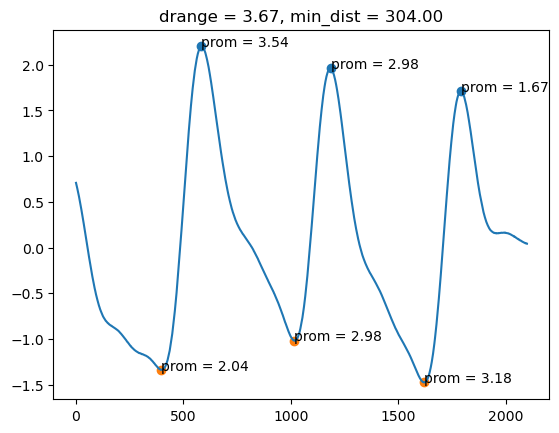

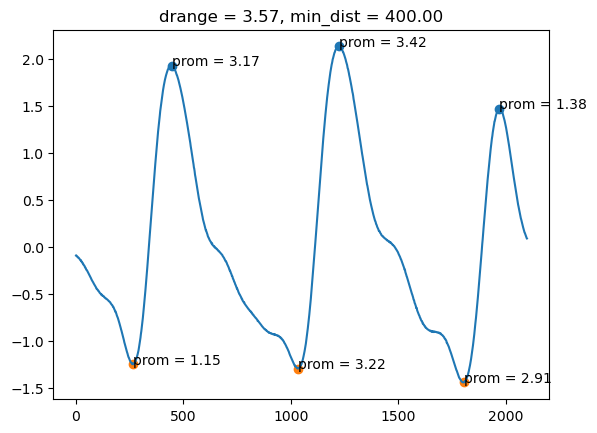

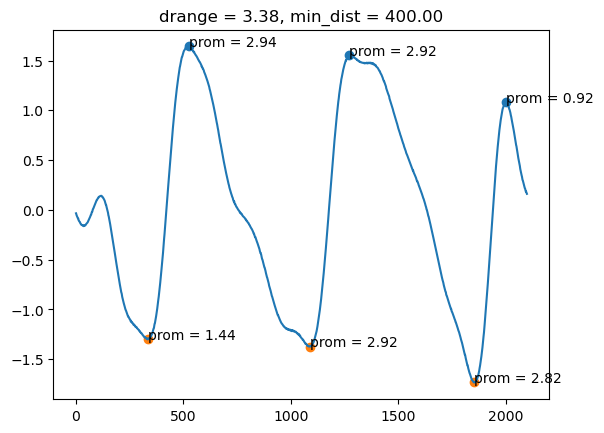

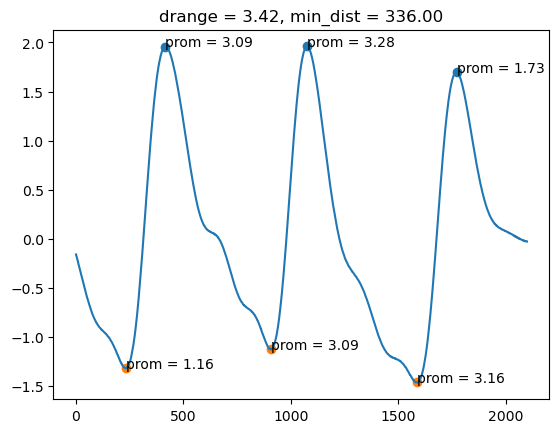

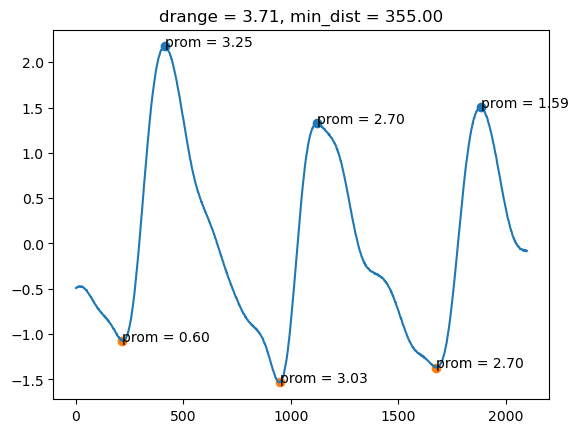

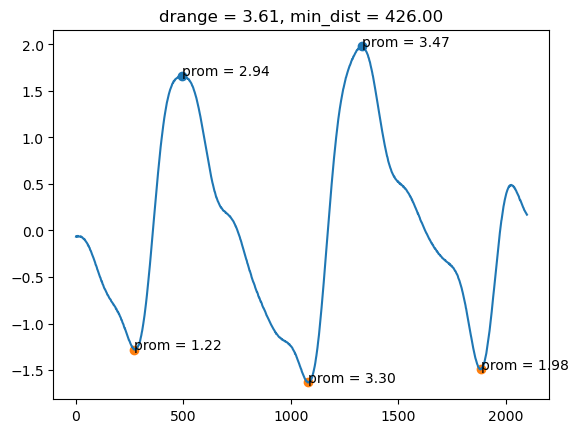

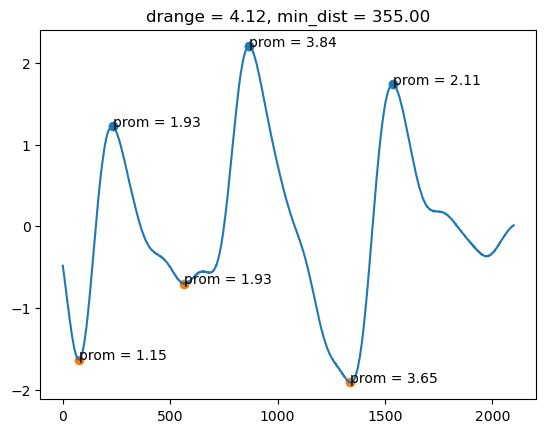

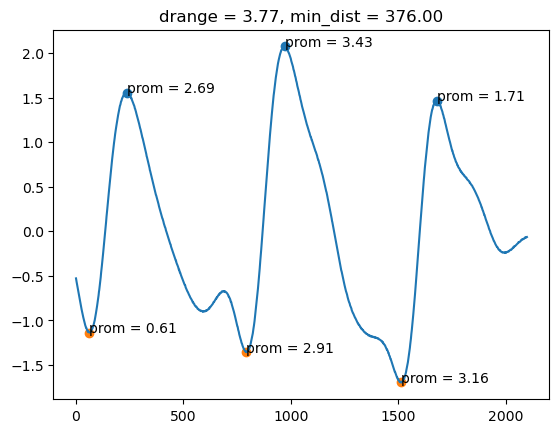

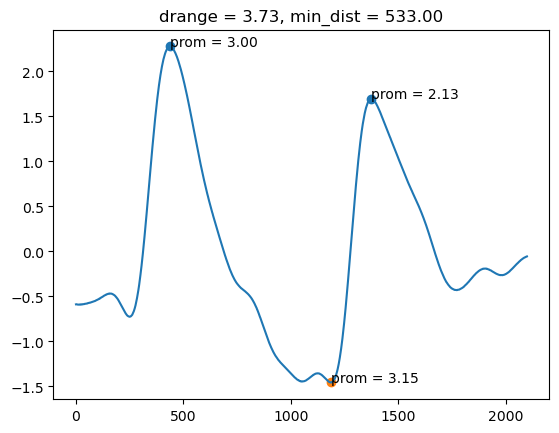

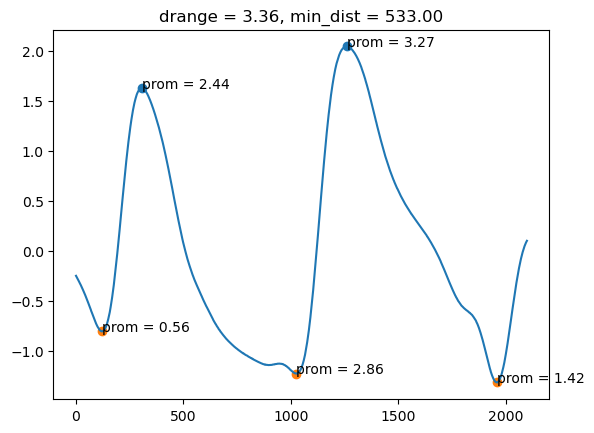

In [238]:
arr = np.loadtxt("ppg.csv", delimiter=",", dtype=float)
for i in range(10):
    ppg_extract_features_persegment(arr[i, :], fs=1000, fl=0.4, fh=8, decimate_q=50, verbose=False)
#plt.plot(arr[0, :]) 
